# Set up

In [1]:
from wsi import filter
from wsi import slide
from wsi import util
from functools import partial
%matplotlib inline

In [2]:
# Replace with WSI file path!
FILE = 'data/U.svs'

In [3]:
slide.slide_info(FILE)


Opening Slide: data/U.svs
Level count: 3
Level dimensions: ((29880, 26128), (7470, 6532), (1867, 1633))
Level downsamples: (1.0, 4.0, 16.002142474558113)
Dimensions: (29880, 26128)
Objective power: 20
Associated images:
  thumbnail: <PIL.Image.Image image mode=RGBA size=878x768 at 0x107257FA0>
Format: aperio
Time elapsed: 0:00:00.032270


RGB                  | Time: 0:00:00.000180  Type: uint8   Shape: (262, 300, 3)


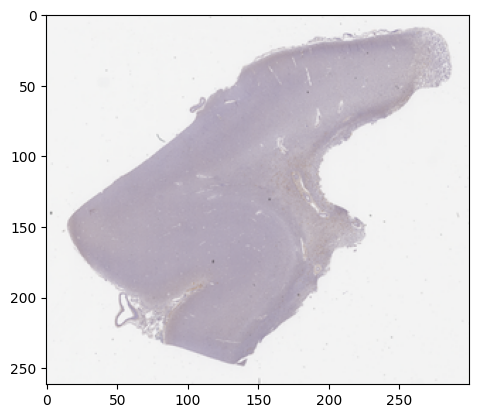

In [4]:
wsi = slide.open_slide(FILE)
img = util.pil_to_np_rgb(wsi.get_thumbnail((300, 500)))
util.display_img(img)

RGB                  | Time: 0:00:00.000802  Type: uint8   Shape: (816, 933, 3)


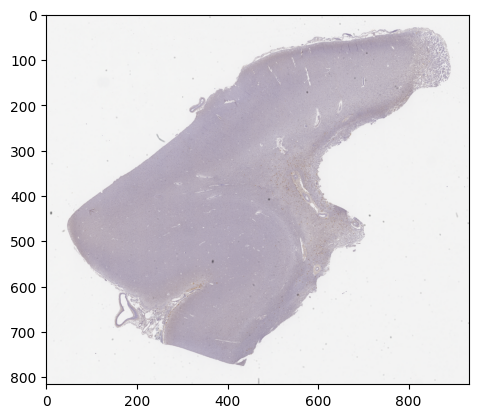

In [5]:
np_img = slide.slide_to_scaled_np_image(FILE, 32)
util.display_img(np_img)

# Complement + Otsu

Gray                 | Time: 0:00:00.017579  Type: uint8   Shape: (816, 933)
Complement           | Time: 0:00:00.000200  Type: uint8   Shape: (816, 933)


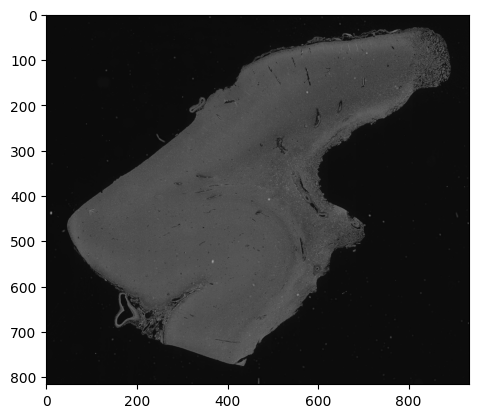

In [6]:
t = util.Time()
grayscale = filter.filter_rgb_to_grayscale(np_img)
complement = filter.filter_complement(grayscale)
util.display_img(complement)

Otsu Threshold       | Time: 0:00:00.010557  Type: uint8   Shape: (816, 933)


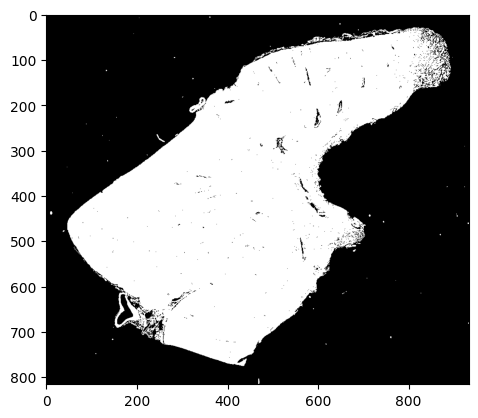

In [7]:
otsu = filter.filter_otsu_threshold(complement)
util.display_img(otsu)
otsu_time = t.elapsed()

Mask RGB             | Time: 0:00:00.003341  Type: uint8   Shape: (816, 933, 3)


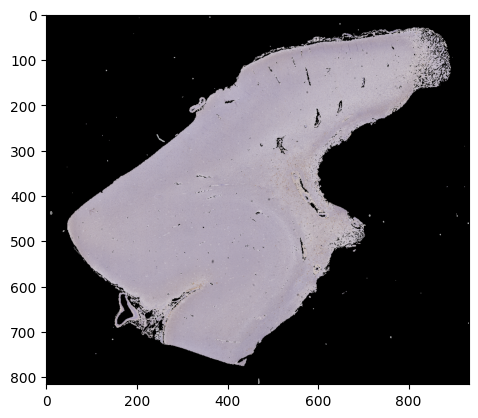

In [8]:
util.display_img(util.mask_rgb(np_img, otsu))

# Median + Saturation + Otsu + Dilation

Source: [A generalized deep learning framework for whole-slide image segmentation and analysis](https://www.nature.com/articles/s41598-021-90444-8)

Median filtering on RGB image

Median               | Time: 0:00:00.684511  Type: uint8   Shape: (816, 933, 3)


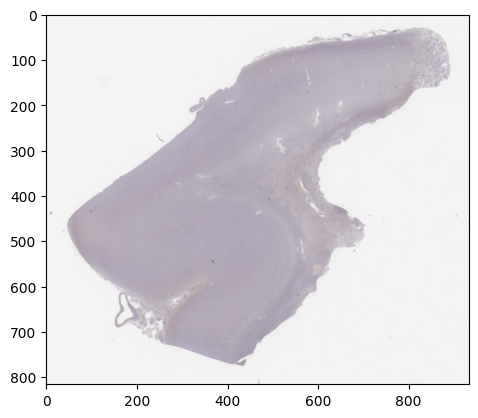

In [9]:
t = util.Time()
md = filter.filter_median(np_img, size=5)
util.display_img(md)

RGB to HSV           | Time: 0:00:00.142816  Type: float64 Shape: (816, 933, 3)


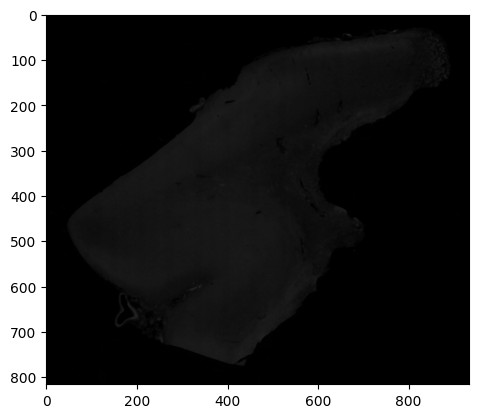

In [10]:
saturation = filter.filter_rgb_to_hsv(md)[:, :, 1]
util.display_img(saturation)

Otsu Threshold       | Time: 0:00:00.013416  Type: uint8   Shape: (816, 933)


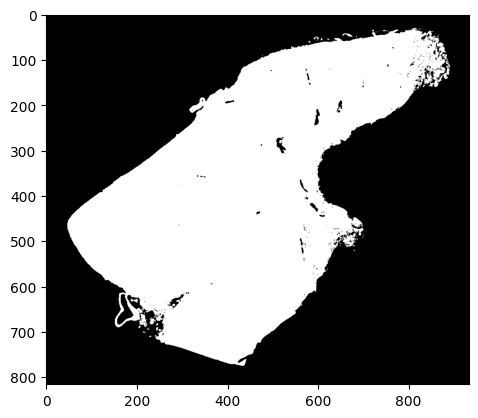

In [11]:
otsu = filter.filter_otsu_threshold(saturation)
util.display_img(otsu)

Binary Dilation      | Time: 0:00:00.047501  Type: uint8   Shape: (816, 933)


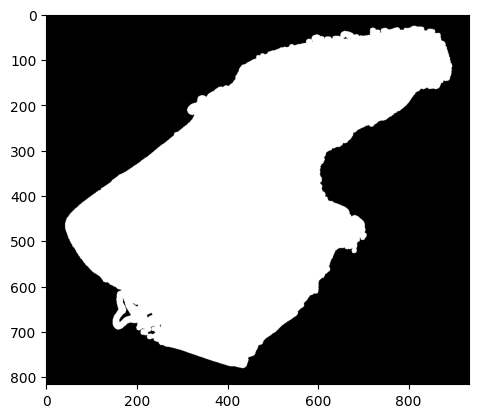

In [12]:
dilation = filter.filter_binary_dilation(otsu, disk_size=5)
util.display_img(dilation)
msod_time = t.elapsed()

Mask RGB             | Time: 0:00:00.003951  Type: uint8   Shape: (816, 933, 3)


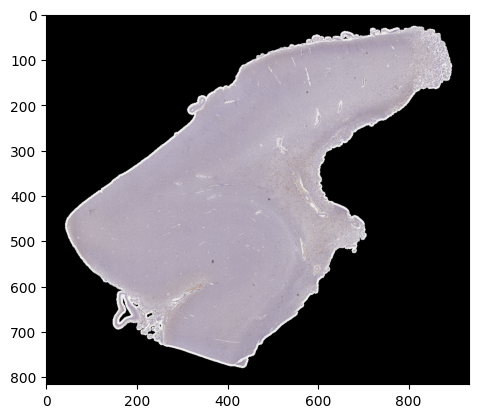

In [13]:
util.display_img(util.mask_rgb(np_img, dilation))

Pipelined filters:

Median               | Time: 0:00:02.330951  Type: uint8   Shape: (816, 933, 3)
RGB to HSV           | Time: 0:00:00.136407  Type: float64 Shape: (816, 933, 3)
Otsu Threshold       | Time: 0:00:00.013153  Type: uint8   Shape: (816, 933)
Binary Dilation      | Time: 0:00:00.046595  Type: uint8   Shape: (816, 933)
Median + Saturation + Ostu + Dilation pipeline | Time: 0:00:02.528464  Type: uint8   Shape: (816, 933)


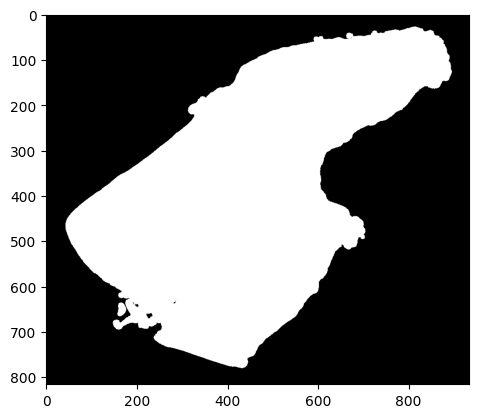

In [14]:
median = partial(filter.filter_median, size=10)
dilation = partial(filter.filter_binary_dilation, disk_size=5)
filtered = filter.filter_pipeline(
  np_img, 
  (
    median,
    filter.filter_rgb_to_hsv,
    (lambda hsv_img: hsv_img[:, : , 1]),
    filter.filter_otsu_threshold,
    dilation
  ),
  "Median + Saturation + Ostu + Dilation pipeline"
  )
util.display_img(filtered)

# Entropy Masker

Source: [An automatic entropy method to efficiently mask histology whole-slide images](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10017682/)

Gray                 | Time: 0:00:00.017607  Type: uint8   Shape: (816, 933)


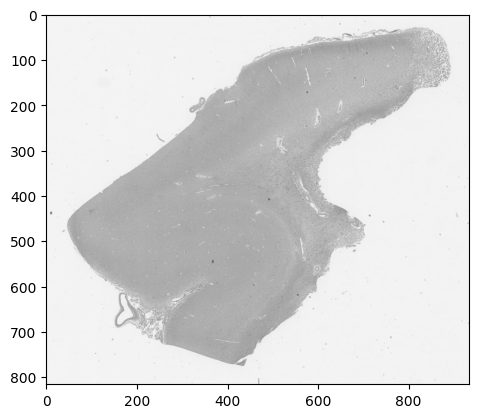

In [15]:
t = util.Time()
grayscale = filter.filter_rgb_to_grayscale(np_img)
util.display_img(grayscale)

Entropy              | Time: 0:00:00.387350  Type: uint8   Shape: (816, 933)


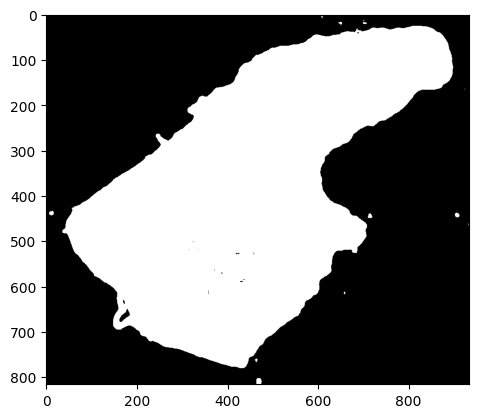

In [16]:
entropy = filter.filter_entropy(grayscale, neighborhood=12, threshold=3)
util.display_img(entropy)
entropy_time = t.elapsed()

Mask RGB             | Time: 0:00:00.003295  Type: uint8   Shape: (816, 933, 3)


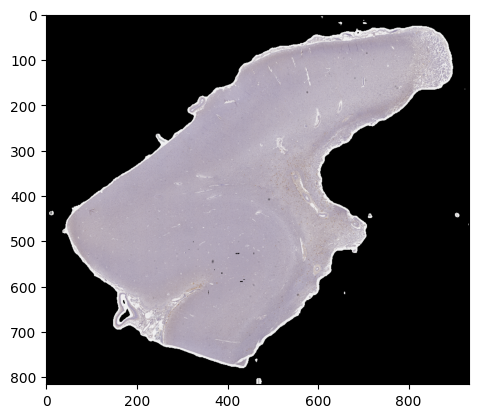

In [17]:
util.display_img(util.mask_rgb(np_img, entropy))

# Performance Comparison

In [18]:
import pandas as pd
data = [["Otsu", str(otsu_time)],
        ["Median + Saturation + Otsu + Dilation", str(msod_time)], 
        ["Entropy", str(entropy_time)]]
table = pd.DataFrame(data, columns=["Method", "Runtime"])
display(table)

,Method,Runtime
0,Otsu,0:00:00.205205
1,Median + Saturation + Otsu + Dilation,0:00:01.416078
2,Entropy,0:00:00.588836


# Filter Multiple WSI files

In [6]:
WSI_DIR = "data"
THUMBNAIL_DIR = "thumbnails"
SCALE = 64
OTSU_DIR = "otsu"
MED_SAT_OT_DI_DIR = "med_sat_ot_di"
ENTROPY_DIR = "entropy"
ENTROPY_FILL_DIR = "entr_fill"

In [20]:
slide.save_slide_dir_thumbnails(WSI_DIR, THUMBNAIL_DIR, SCALE)

## Otsu

In [21]:
otsu_pipeline = [
  partial(filter.filter_rgb_to_grayscale, display_info=False),
  partial(filter.filter_complement, display_info=False),
  partial(filter.filter_otsu_threshold, display_info=False)
]
filter.filter_img_dir(
  THUMBNAIL_DIR,
  OTSU_DIR,
  otsu_pipeline,
  "Otsu pipeline"
)
filter.mask_img_dir(THUMBNAIL_DIR, OTSU_DIR)

UUU.png
Otsu pipeline        | Time: 0:00:00.019010  Type: uint8   Shape: (714, 995)
----------------------------------------------------------------------
UU.png
Otsu pipeline        | Time: 0:00:00.014633  Type: uint8   Shape: (565, 964)
----------------------------------------------------------------------
RRR.png
Otsu pipeline        | Time: 0:00:00.013097  Type: uint8   Shape: (606, 809)
----------------------------------------------------------------------
TT.png
Otsu pipeline        | Time: 0:00:00.011921  Type: uint8   Shape: (519, 839)
----------------------------------------------------------------------
RR.png
Otsu pipeline        | Time: 0:00:00.008375  Type: uint8   Shape: (548, 559)
----------------------------------------------------------------------
SSS.png
Otsu pipeline        | Time: 0:00:00.016515  Type: uint8   Shape: (714, 871)
----------------------------------------------------------------------
TTT.png
Otsu pipeline        | Time: 0:00:00.015327  Type: uint8   

## Median + Saturation + Otsu + Dilation

In [7]:
msod_pipeline = [
    partial(filter.filter_median_scale, size_scale=3, display_info=False),
    partial(filter.filter_rgb_to_hsv, display_info=False),
    (lambda hsv_img: hsv_img[:, : , 1]),
    partial(filter.filter_otsu_threshold, display_info=False),
    partial(filter.filter_binary_dilation_scale, disk_size_scale=1, display_info=False),
]
filter.filter_img_dir(
  THUMBNAIL_DIR, 
  MED_SAT_OT_DI_DIR, 
  msod_pipeline, 
  "Median + Saturation + Ostu + Dilation pipeline"
  )
filter.mask_img_dir(THUMBNAIL_DIR, MED_SAT_OT_DI_DIR)

UUU.png
Median + Saturation + Ostu + Dilation pipeline | Time: 0:00:12.796531  Type: uint8   Shape: (714, 995)
----------------------------------------------------------------------
UU.png
Median + Saturation + Ostu + Dilation pipeline | Time: 0:00:07.756110  Type: uint8   Shape: (565, 964)
----------------------------------------------------------------------
RRR.png
Median + Saturation + Ostu + Dilation pipeline | Time: 0:00:06.739698  Type: uint8   Shape: (606, 809)
----------------------------------------------------------------------
TT.png
Median + Saturation + Ostu + Dilation pipeline | Time: 0:00:04.513139  Type: uint8   Shape: (519, 839)
----------------------------------------------------------------------
RR.png
Median + Saturation + Ostu + Dilation pipeline | Time: 0:00:02.439905  Type: uint8   Shape: (548, 559)
----------------------------------------------------------------------
SSS.png
Median + Saturation + Ostu + Dilation pipeline | Time: 0:00:09.057071  Type: uint8   

## Entropy

In [9]:
entr_pipeline = [
  partial(filter.filter_rgb_to_grayscale, display_info=False),
  partial(filter.filter_entropy_scale, neighborhood_scale=3, threshold=3, display_info=False)
]
filter.filter_img_dir(
  THUMBNAIL_DIR,
  ENTROPY_DIR,
  entr_pipeline,
  "Entropy pipeline"
)
filter.mask_img_dir(THUMBNAIL_DIR, ENTROPY_DIR)

UUU.png
Entropy pipeline     | Time: 0:00:00.459751  Type: uint8   Shape: (714, 995)
----------------------------------------------------------------------
UU.png
Entropy pipeline     | Time: 0:00:00.584010  Type: uint8   Shape: (565, 964)
----------------------------------------------------------------------
RRR.png
Entropy pipeline     | Time: 0:00:00.320904  Type: uint8   Shape: (606, 809)
----------------------------------------------------------------------
TT.png
Entropy pipeline     | Time: 0:00:00.244610  Type: uint8   Shape: (519, 839)
----------------------------------------------------------------------
RR.png
Entropy pipeline     | Time: 0:00:00.192221  Type: uint8   Shape: (548, 559)
----------------------------------------------------------------------
SSS.png
Entropy pipeline     | Time: 0:00:00.382388  Type: uint8   Shape: (714, 871)
----------------------------------------------------------------------
TTT.png
Entropy pipeline     | Time: 0:00:00.299985  Type: uint8   

## Entropy + Fill Holes

In [10]:
entr_fill_pipeline = [
  partial(filter.filter_rgb_to_grayscale, display_info=False),
  partial(filter.filter_entropy_scale, neighborhood_scale=3, threshold=3, display_info=False),
  partial(filter.filter_binary_fill_holes, display_info=False)
]
filter.filter_img_dir(
  THUMBNAIL_DIR,
  ENTROPY_FILL_DIR,
  entr_fill_pipeline,
  "Entropy + Fill holes pipeline"
)
filter.mask_img_dir(
  THUMBNAIL_DIR,
  ENTROPY_FILL_DIR
)

UUU.png
Entropy + Fill holes pipeline | Time: 0:00:00.466235  Type: bool    Shape: (714, 995)
----------------------------------------------------------------------
UU.png
Entropy + Fill holes pipeline | Time: 0:00:00.381673  Type: bool    Shape: (565, 964)
----------------------------------------------------------------------
RRR.png
Entropy + Fill holes pipeline | Time: 0:00:00.341007  Type: bool    Shape: (606, 809)
----------------------------------------------------------------------
TT.png
Entropy + Fill holes pipeline | Time: 0:00:00.258041  Type: bool    Shape: (519, 839)
----------------------------------------------------------------------
RR.png
Entropy + Fill holes pipeline | Time: 0:00:00.201697  Type: bool    Shape: (548, 559)
----------------------------------------------------------------------
SSS.png
Entropy + Fill holes pipeline | Time: 0:00:00.481882  Type: bool    Shape: (714, 871)
----------------------------------------------------------------------
TTT.png
Entro